In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import time
import sys
import time
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from scipy.optimize import rosen
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ['CUDA_MPS_PIPE_DIRECTORY'] = "/tmp/nvidia-mps"
os.environ['CUDA_MPS_LOG_DIRECTORY'] = "/tmp/nvidia-log"

In [3]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def get_errors(x_, y_): # return rmse, mae, maxae
    x_ = x_.squeeze()
    y_ = y_.squeeze()
    return [np.sqrt(mse(x_, y_)), np.mean(np.abs(x_ - y_)), np.max(np.abs(x_ - y_))]

def get_mcdues_nn(X, sess, y, x, keep_probability_, p = .5, T=100): # returns MCD UEs
    stds = np.zeros((X.shape[0], T), dtype = float)
    for cnt_ in range(T):
        stds[:, cnt_] = np.ravel(sess.run(y, feed_dict={x: X, 
                                                        keep_probability_: p}))
    return np.std(stds, axis = 1)

In [4]:
def random_sampling(X_pool, y_pool, points_to_sample):
    random_indices = np.random.permutation(X_pool.shape[0])[:points_to_sample]
    X_sample = X_pool[random_indices, :]
    y_sample = y_pool[random_indices, :]
    X_pool = np.delete(X_pool, random_indices, 0)
    y_pool = np.delete(y_pool, random_indices, 0)
    
    return X_pool, y_pool, X_sample, y_sample

def GMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample): # greedy (classic) MCDUE
    mcd_indices = np.argsort(get_mcdues_nn(X_pool, sess, y, x, keep_probability_))[-points_to_sample:]
    X_sample = X_pool[mcd_indices, :]
    y_sample = y_pool[mcd_indices, :]
    X_pool = np.delete(X_pool, mcd_indices, 0)
    y_pool = np.delete(y_pool, mcd_indices, 0)
    
    return X_pool, y_pool, X_sample, y_sample

def DMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample): # Distribution MCDUE
    mcds = get_mcdues_nn(X_pool, sess, y, x, keep_probability_) 
    log_mcds = np.ma.log(mcds).filled(0)
    x_dist = sns.distplot(log_mcds).get_lines()[0].get_data()[0]
    y_dist = sns.distplot(log_mcds).get_lines()[0].get_data()[1]
    derivatives = np.empty(x_dist.shape[0] - 1)
    for i in range(derivatives.shape[0]):
        derivatives[i] = (y_dist[i + 1] - y_dist[i]) / (x_dist[i + 1] - x_dist[i])
    tmp_der = derivatives
    threshold = 1 # Threshold for derivative
    derivatives[abs(derivatives) < threshold] = 0
    while((derivatives==np.zeros(derivatives.shape[0])).sum() >= derivatives.shape[0] - 1): # If threshold is too high
        derivatives = tmp_der
        threshold *= 0.9
        derivatives[abs(derivatives) < threshold] = 0       
        
    last_point = np.where(derivatives < 0)[0][-1] + 1
    ind_where = np.argwhere(log_mcds <= x_dist[last_point]).squeeze()
    indices = np.argsort(mcds[ind_where])
    
    indices = ind_where[indices][-points_to_sample:]
    
    X_sample = X_pool[indices, :]
    y_sample = y_pool[indices, :]
    X_pool = np.delete(X_pool, indices, 0)
    y_pool = np.delete(y_pool, indices, 0)
    
    return X_pool, y_pool, X_sample, y_sample

In [5]:
def model_loader(layers,  path, lr): # Load a model of a particular architecture
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, [None, ndim], name='x')
    y_ = tf.placeholder(tf.float32, [None, 1], name='true_answers')

    learning_rate_ = tf.placeholder(tf.float32)
    forces_coeff_ = tf.placeholder(tf.float32)
    keep_probability_ = tf.placeholder(tf.float32, name='keep_probability')
    l2_reg_ = tf.placeholder(tf.float32, name='l2reg')

    initializer = tf.contrib.layers.xavier_initializer()
    W1 = tf.Variable(initializer((ndim, layers[0])))
    b1 = tf.Variable(initializer((layers[0],)))
    h1 = tf.nn.leaky_relu(tf.matmul(x, W1) + b1, alpha=0.01)

    h_drop1 = tf.nn.dropout(h1, keep_probability_, noise_shape = [1,layers[0]])

    Ws = [W1]; bs = [b1]; hs = [h_drop1]
    for cnt_layer in range(1, len(layers)):
        Ws.append(tf.Variable(initializer((layers[cnt_layer - 1], layers[cnt_layer])), name='weights'))
        bs.append(tf.Variable(initializer((layers[cnt_layer],)), name='biases'))
        hs.append(tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(hs[-1], Ws[-1]) + bs[-1], alpha=0.01, name='leaky_relu_activations'), keep_probability_,
                                noise_shape = [1,layers[cnt_layer]]))


    Ws.append(tf.Variable(initializer((layers[-1], 1)), name='weights'))
    bs.append(tf.Variable(initializer((1,)), name='biases'))
    # funcs
    y = tf.matmul(hs[-1], Ws[-1]) + bs[-1]

    l2_regularizer = sum(tf.nn.l2_loss(Wxxx) for Wxxx in Ws) 

    mse_e = tf.losses.mean_squared_error(predictions = y, labels = y_)

    loss = mse_e + l2_reg_*l2_regularizer

    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

    try:
        sess.close()
    except:
        pass

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session(config=config)
    sess.run(init)
    
    saver = tf.train.Saver()
    saver.restore(sess, path) # Loading
    
    return sess, y, y_, x, l2_reg_, keep_probability_, saver, train_step, loss

In [6]:
def create_model(X_train, y_train, layers, path, lr, keeps_train, init_epochs_train, batch_size_train):
    # Creates and trains a model on training set and saves it
    
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, [None, ndim], name='x')
    y_ = tf.placeholder(tf.float32, [None, 1], name='true_answers')

    learning_rate_ = tf.placeholder(tf.float32)
    forces_coeff_ = tf.placeholder(tf.float32)
    keep_probability_ = tf.placeholder(tf.float32, name='keep_probability')
    l2_reg_ = tf.placeholder(tf.float32, name='l2reg')

    initializer = tf.contrib.layers.xavier_initializer()
    W1 = tf.Variable(initializer((ndim, layers[0])))
    b1 = tf.Variable(initializer((layers[0],)))
    h1 = tf.nn.leaky_relu(tf.matmul(x, W1) + b1, alpha=0.01)

    h_drop1 = tf.nn.dropout(h1, keep_probability_, noise_shape = [1,layers[0]])

    Ws = [W1]; bs = [b1]; hs = [h_drop1]
    for cnt_layer in range(1, len(layers)):
        Ws.append(tf.Variable(initializer((layers[cnt_layer - 1], layers[cnt_layer])), name='weights'))
        bs.append(tf.Variable(initializer((layers[cnt_layer],)), name='biases'))
        hs.append(tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(hs[-1], Ws[-1]) + bs[-1], alpha=0.01, name='leaky_relu_activations'), keep_probability_,
                                noise_shape = [1,layers[cnt_layer]]))


    Ws.append(tf.Variable(initializer((layers[-1], 1)), name='weights'))
    bs.append(tf.Variable(initializer((1,)), name='biases'))
    # funcs
    y = tf.matmul(hs[-1], Ws[-1]) + bs[-1]

    l2_regularizer = sum(tf.nn.l2_loss(Wxxx) for Wxxx in Ws) 

    mse_e = tf.losses.mean_squared_error(predictions = y, labels = y_)
    loss = mse_e + l2_reg_*l2_regularizer

    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

    try:
        sess.close()
    except:
        pass

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session(config=config)
    sess.run(init)

    
    train_nn(X_train, y_train, sess, y, y_, x, l2_reg_, keep_probability_, keeps_train, saver, train_step, loss, init_epochs_train, batch_size_train)
    save_path = saver.save(sess, path) # Saves the model
    print('model is saved: ', save_path)

In [7]:
def train_nn(X_tr, y_tr, sess, y, y_, x, l2_reg_, keep_probability_, kp, saver,
             train_step, loss, init_epochs, batch_size, X_test=None, y_test=None):

    print('pos 1')
    if(not type(kp)==type([])):
        keeps = [kp]
    else:
        keeps = kp
    current_error = 1e+10
    patience = 0
    for keep_prob in keeps:
        for cnt in range(init_epochs):
            for batch in iterate_minibatches(X_tr, y_tr, batch_size):
                X_batch, y_batch = batch
                sess.run(train_step, feed_dict={x: X_batch, 
                                                y_: y_batch, 
                                                keep_probability_: keep_prob, 
                                                l2_reg_: 1e-5})
            if cnt % 100 == 0:
                preds_train = sess.run(y, feed_dict= {x: X_tr , keep_probability_: 1})
                train_err = get_errors(preds_train.squeeze(), y_tr.squeeze())[0]
                if train_err > current_error:
                    patience += 1
                if patience > 2:
                    print(f'Early stopping in epoch {cnt}')
                    break
                current_error = train_err
                
    print('pos 2')
        
    if(X_test is not None): # estimate error on test
        preds_train = sess.run(y, feed_dict= {x: X_tr , keep_probability_: 1})
        preds_test = sess.run(y, feed_dict= {x: X_test , keep_probability_: 1})
        test_err =  get_errors(preds_test.squeeze(), y_test.squeeze())
        train_err = get_errors(preds_train.squeeze(), y_tr.squeeze())
        return test_err, train_err
    else:
        return

In [8]:
def generate_data(size, d, random_state):
    random_state = random_state
    np.random.seed(random_state)
    randmat = np.random.uniform(size = d * size).reshape(size, d)
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))

    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    N_total = len(df)
    N_train, N_test, N_val, N_pool = (int(tmp*N_total) for tmp in split_share)

    X_train = df[:N_train].values
    y_train = targets[:N_train][:, None]
    X_test = df[N_train:(N_train + N_test)].values
    y_test = targets[N_train:(N_train + N_test)][:, None]
    X_pool = df[-N_pool:].values
    y_pool = targets[-N_pool:][:, None]
    X_val = df[-(N_val+N_pool):-N_pool].values
    y_val = targets[-(N_val+N_pool):-N_pool][:, None]
    print('Train shapes:', X_train.shape, y_train.shape)
    print('Test shapes:', X_test.shape, y_train.shape)
    print('Pool shapes:', X_pool.shape, y_pool.shape)
    print('Validation shapes:', X_val.shape, y_val.shape)
    return X_train, y_train, X_test, y_test, X_pool, y_pool, X_val, y_val

In [9]:
# Parameters for the NN

size = 20000 # size of Rosenbrock dataset
dimentionality = 10 # dimentionality of Rosenbrock
split_share = (.2, .2, .0, .6) # Train, Test, Pool, Validation
random_states = [] # contains all random_states were used



folder = 'rosenbrock_models_layers_corrected' # this is just a folder name for models, where I vary a number of layers


# Training parameters
init_epochs_train = 10000 # Number of epoches for training
batch_size_train = 100 # Training batchsize
keeps_train = [.95]
lr_train = 1e-5

# AL parameters
init_epochs = 3000
batch_size = 85
keeps = [0.975]
lr_al = 1e-5


num_of_iterations = 20 # How many points iterations of AL to do?
tolerance = 3e+10 # Early stopping after 'tolerance' iterations
repetitions = 10 # How many runs, over which we will average


# Layers = [[256, 64], [256, 128, 64], [256, 128, 128, 64], [256, 128, 128, 128, 64], [256, 128, 128, 128, 128, 64]]
# Layers = [[256, 64], [256, 128, 128, 64]][::-1]
Layers = [[256, 128, 128, 128, 128, 64]]

[256, 128, 128, 128, 128, 64]
Train shapes: (4000, 10) (4000, 1)
Test shapes: (4000, 10) (4000, 1)
Pool shapes: (12000, 10) (12000, 1)
Validation shapes: (0, 10) (0, 1)
How many points to sample:  300
pos 1
Early stopping in epoch 3500
pos 2
model is saved:  ./rosenbrock_models_layers_corrected/6/model_6.ckpt
random_sampling 0
INFO:tensorflow:Restoring parameters from ./rosenbrock_models_layers_corrected/6/model_6.ckpt
Train errors:  [14.424611383854852, 11.154901656785093, 68.09265737064663]
Test errors:  [16.529952703373475, 12.63656185442389, 87.98004472981467]
pos 1
Early stopping in epoch 1800
pos 2
[8.638703549749316, 6.8203784624594235, 35.271651817245214]
[11.484298425516052, 8.864335975618514, 57.132657398511725]
pos 1
Early stopping in epoch 700
pos 2
[8.628483652904201, 6.749739451989846, 39.23489980228726]
[11.31314440408939, 8.585832984965865, 62.206526538869014]
pos 1
Early stopping in epoch 1200
pos 2
[7.339834527796436, 5.761620358019317, 32.012926874875234]
[9.92934473

pos 1
Early stopping in epoch 700
pos 2
[6.126863926380493, 4.861773083096018, 25.555578192428413]
[7.628573962290565, 5.9371667368886625, 39.94398247175391]
pos 1
Early stopping in epoch 800
pos 2
[6.38856289359261, 5.001802752246385, 31.859552477823343]
[7.277277837119052, 5.538518021833741, 46.18326128254904]
10
pos 1
Early stopping in epoch 900
pos 2
[5.566921285553772, 4.355298716067875, 26.686029528604593]
[6.7117024976109825, 5.0951686940415675, 46.21206987629904]
pos 1
Early stopping in epoch 700
pos 2
[7.406398860410364, 6.0069303574828306, 29.157404040323343]
[7.695415119722025, 5.886430783622235, 52.13492143879904]
pos 1
Early stopping in epoch 600
pos 2
[6.234582095109376, 4.973768365765284, 25.173715685831155]
[6.8718392926728225, 5.205388648875974, 49.728518850908415]
pos 1
Early stopping in epoch 1200
pos 2
[4.657320702756351, 3.665008913040981, 18.67180133938035]
[5.927505548229194, 4.5067595981739865, 44.34628618489279]
pos 1
Early stopping in epoch 500
pos 2
[6.627128

pos 1
Early stopping in epoch 700
pos 2
[6.4034178086143285, 5.143134259011708, 26.121854655164896]
[6.8567438163344665, 5.284910530660736, 32.85309601986455]
pos 1
Early stopping in epoch 900
pos 2
[6.567060597898569, 5.336617458299094, 27.64068400086802]
[6.922878831624314, 5.355428474249106, 32.35477448666143]
pos 1
Early stopping in epoch 400
pos 2
[6.401064270234624, 5.202635481779966, 27.400907389539896]
[6.790515011107376, 5.257138422682822, 32.24719141875511]
pos 1
Early stopping in epoch 300
pos 2
[7.551354854534841, 6.307309925970492, 30.360563151258646]
[7.636733393817444, 5.980520165494819, 33.36144923125511]
20
pos 1
Early stopping in epoch 600
pos 2
[5.2009582758355695, 4.13878445332574, 24.14649314807525]
[5.967914998731186, 4.601839221991348, 29.899168957817608]
dmcdue_sampling 1
INFO:tensorflow:Restoring parameters from ./rosenbrock_models_layers_corrected/6/model_6.ckpt
pos 1
Early stopping in epoch 2700
pos 2
[10.193677366025971, 7.879919585498477, 46.22012991073038]

pos 1
Early stopping in epoch 700
pos 2
[10.505739991375366, 8.126684865665581, 49.59964995983216]
[11.162876045474338, 8.550256288292207, 57.38311743931456]
pos 1
Early stopping in epoch 700
pos 2
[7.969149810820455, 6.1223214446342, 40.22562652233216]
[9.193291670616945, 7.07580185514963, 49.286407234236435]
pos 1
Early stopping in epoch 600
pos 2
[8.61397632450746, 6.7156075777593, 42.71610503795716]
[9.399692016878463, 7.219731231894864, 48.07568335728331]
pos 1
Early stopping in epoch 500
pos 2
[8.387111048887666, 6.549029536924768, 40.45234161022279]
[9.067909998367146, 6.954910709903338, 45.81689429478331]
pos 1
Early stopping in epoch 500
pos 2
[7.344639945004464, 5.698881784011171, 35.46015411022279]
[8.27935936037142, 6.351179970945861, 41.79351782993956]
pos 1
Early stopping in epoch 400
pos 2
[7.863282229530319, 6.172269791568575, 36.49552222697565]
[8.476519720600205, 6.496089090582887, 41.60245746879832]
10
pos 1
Early stopping in epoch 500
pos 2
[6.9512570683134784, 5.43

Early stopping in epoch 700
pos 2
[5.275955383811239, 4.120685524493364, 33.569105130583694]
[6.819295140542817, 5.163858156768081, 32.21729658484145]
pos 1
Early stopping in epoch 800
pos 2
[5.693012102574897, 4.539679209591169, 30.726331693083694]
[7.0806575094668815, 5.430969942241736, 31.99723367520494]
pos 1
Early stopping in epoch 700
pos 2
[5.79069387412388, 4.626128512192314, 29.196653800638728]
[7.121911348859998, 5.471758165259117, 32.37134931921645]
pos 1
Early stopping in epoch 700
pos 2
[4.566113519800648, 3.558040253811884, 25.190672355326228]
[6.114257010967155, 4.6381170667445675, 29.086985872470564]
pos 1
Early stopping in epoch 800
pos 2
[4.119537656207229, 3.1895519776929837, 24.43369863644307]
[5.756809713922457, 4.370120897695493, 26.036540969607074]
pos 1
Early stopping in epoch 800
pos 2
[6.687803372567222, 5.518809000376196, 30.430372220427444]
[7.753047811762486, 6.105687411911934, 30.5862541043727]
pos 1
Early stopping in epoch 600
pos 2
[4.7406720035397765, 3

INFO:tensorflow:Restoring parameters from ./rosenbrock_models_layers_corrected/6/model_6.ckpt
Train errors:  [16.26870748251081, 12.69404471055415, 74.66273191159922]
Test errors:  [17.9463875985195, 13.906613986699243, 84.11715887801807]
pos 1
Early stopping in epoch 2400
pos 2
[9.588867075132653, 7.463997958673683, 45.154003884255474]
[12.18187768967693, 9.404718817352888, 65.63497684763763]
pos 1
Early stopping in epoch 1300
pos 2
[7.677291364228133, 5.975036284936976, 31.160184536019443]
[10.322235059578398, 7.896555118965514, 54.128232462872006]
pos 1
Early stopping in epoch 1000
pos 2
[7.467878212322476, 5.805277161334587, 30.21425514064464]
[9.919735575930615, 7.53122085260967, 50.745053751934506]
pos 1
Early stopping in epoch 300
pos 2
[7.020882712359245, 5.4552907876879155, 35.619184626628794]
[9.436814913426343, 7.146762397905561, 48.163327677715756]
pos 1
Early stopping in epoch 600
pos 2
[6.841309008147084, 5.3092984857726515, 36.871388480088285]
[9.12676138564942, 6.881565

pos 1
Early stopping in epoch 500
pos 2
[6.082333860552128, 4.758945597799976, 26.282838281587544]
[6.9796253720713155, 5.29755063997906, 43.24880741404388]
pos 1
Early stopping in epoch 800
pos 2
[6.750311129288129, 5.363149570941826, 25.234943040047597]
[7.294116320265902, 5.548081967896647, 42.365354044903256]
pos 1
Early stopping in epoch 900
pos 2
[5.378975280263447, 4.225675517422072, 22.681398183156148]
[6.327239261798204, 4.799397089963785, 39.836301310528256]
pos 1
Early stopping in epoch 800
pos 2
[5.2983065724574985, 4.170366484036695, 22.243715077687398]
[6.1960369699963325, 4.7038074106128045, 39.467587931622006]
pos 1
Early stopping in epoch 500
pos 2
[6.357283869865648, 5.122736255569364, 24.039338856984273]
[6.819007029804549, 5.218083231545105, 40.39718387888763]
pos 1
Early stopping in epoch 500
pos 2
[5.521502185113801, 4.383510788761105, 22.182496815968648]
[6.20762200645263, 4.720938342367267, 39.65017460154388]
pos 1
Early stopping in epoch 600
pos 2
[5.9315588716

pos 1
Early stopping in epoch 400
pos 2
[7.184705483572409, 5.9357702420818494, 26.722132430480144]
[7.207440223649894, 5.5733424940718015, 32.560489703365306]
20
pos 1
Early stopping in epoch 500
pos 2
[6.73924094103449, 5.526836518808157, 26.339811876381418]
[6.864472560515753, 5.292325389940495, 31.365055133052806]
dmcdue_sampling 5
INFO:tensorflow:Restoring parameters from ./rosenbrock_models_layers_corrected/6/model_6.ckpt
pos 1
Early stopping in epoch 1300
pos 2
[12.198374522745967, 9.54249221692859, 67.98906532622152]
[13.876744672038424, 10.66865702906907, 70.71393776486877]
pos 1
Early stopping in epoch 1700
pos 2
[9.163805964450793, 7.11034910993193, 51.77098671294027]
[10.969573925104534, 8.386391203313625, 56.86771016234968]
pos 1
Early stopping in epoch 1400
pos 2
[8.028786305974702, 6.192136345669096, 45.789877093799646]
[9.568227370481065, 7.273197004260317, 50.326364522681274]
pos 1
Early stopping in epoch 1200
pos 2
[7.453254330416863, 5.767772747753871, 41.32411781645

pos 1
Early stopping in epoch 600
pos 2
[7.199309834037328, 5.589767740992765, 33.27396829559484]
[8.048600243137399, 6.174507829980422, 42.5703838970519]
pos 1
Early stopping in epoch 800
pos 2
[6.365339676257191, 4.95569811959403, 29.781750278016716]
[7.39759288491392, 5.679247468320201, 35.99625669978627]
pos 1
Early stopping in epoch 700
pos 2
[6.725622794594357, 5.22439054312724, 30.645214633485466]
[7.310361538224383, 5.588800529568782, 36.70618711970815]
10
pos 1
Early stopping in epoch 600
pos 2
[5.953867105285338, 4.642552782460014, 28.009955752608988]
[6.799033548646255, 5.22034773587852, 36.51349227060825]
pos 1
Early stopping in epoch 500
pos 2
[5.930461825884286, 4.619957294009511, 26.5672830231168]
[6.664727736199111, 5.112571690675581, 34.537601157327]
pos 1
Early stopping in epoch 600
pos 2
[6.187836309471488, 4.826257983788495, 26.565636508489774]
[6.644886325974149, 5.0910202287050526, 34.432132407327]
pos 1
Early stopping in epoch 700
pos 2
[8.648706138673631, 7.1045

Early stopping in epoch 800
pos 2
[3.987335530894683, 3.0844054057276935, 21.768724637190758]
[5.593075803467205, 4.257025713376707, 30.799375950902686]
pos 1
Early stopping in epoch 400
pos 2
[4.229912713660219, 3.277272451019361, 22.719828587387497]
[5.725017271396916, 4.346034860058351, 32.784544407933936]
pos 1
Early stopping in epoch 300
pos 2
[4.369203731321829, 3.3820635776770036, 22.618634238152254]
[5.798951664217448, 4.399113777112397, 32.583006321996436]
pos 1
Early stopping in epoch 600
pos 2
[3.8998164879775437, 3.0233426931955334, 20.05781270494913]
[5.399867206643079, 4.130763901652675, 31.49775546750425]
20
pos 1
Early stopping in epoch 600
pos 2
[3.800388810256552, 2.956759003740995, 19.508160605339754]
[5.289509559384934, 4.064649300733078, 31.25271457394956]
gmcdue_sampling 7
INFO:tensorflow:Restoring parameters from ./rosenbrock_models_layers_corrected/6/model_6.ckpt
pos 1
Early stopping in epoch 2300
pos 2
[9.856966418236134, 7.654612660821035, 43.40735001406205]
[

Early stopping in epoch 400
pos 2
[5.522900234624307, 4.286915338481037, 31.739695806803127]
[8.119247460571392, 6.23468468959612, 40.03000154220172]
pos 1
Early stopping in epoch 400
pos 2
[6.262459226571583, 4.870500054494651, 35.354899664225]
[8.441112222302793, 6.292784948079994, 48.63272371017047]
pos 1
Early stopping in epoch 700
pos 2
[5.119243920097521, 3.9444155524269355, 30.741221685709377]
[7.519438316302508, 5.623396212515471, 48.59323396407672]
pos 1
Early stopping in epoch 1100
pos 2
[5.341712375251449, 4.129770072199601, 31.40061499625625]
[7.4714431583246474, 5.538307254466654, 45.990679642787654]
pos 1
Early stopping in epoch 400
pos 2
[4.704649082267586, 3.6144561745155634, 29.3594162657875]
[6.906909305019835, 5.184786326719835, 43.19681062423297]
pos 1
Early stopping in epoch 400
pos 2
[5.505910305575603, 4.282927912724954, 30.153880377115627]
[7.36296936466174, 5.499575136744766, 44.13199128829547]
10
pos 1
Early stopping in epoch 500
pos 2
[5.023977356011258, 3.88

pos 1
Early stopping in epoch 600
pos 2
[5.323619165293812, 4.227531896023964, 22.664576386977387]
[6.332401040805335, 4.8940825847659335, 34.53833284102984]
pos 1
Early stopping in epoch 300
pos 2
[5.245713905011812, 4.158532174972065, 21.741541719008637]
[6.234273072686449, 4.813009225137196, 33.89642610274859]
pos 1
Early stopping in epoch 500
pos 2
[5.267178934263706, 4.198111187516545, 21.742915010024262]
[6.207969645240113, 4.78405094694821, 30.586916825404842]
pos 1
Early stopping in epoch 400
pos 2
[4.932405758314619, 3.9081920303728213, 21.1741036319537]
[5.980238248271504, 4.593111916840183, 30.000002762904842]
pos 1
Early stopping in epoch 500
pos 2
[4.734875999979832, 3.7579816347837807, 20.377503290156824]
[5.843331103736577, 4.482665866382775, 28.533846757045467]
20
pos 1
Early stopping in epoch 600
pos 2
[5.67246046086112, 4.575898036426802, 23.683289422969324]
[6.393686311685605, 4.89528383787072, 29.017572548747182]
Train shapes: (4000, 10) (4000, 1)
Test shapes: (4000

pos 1
Early stopping in epoch 1200
pos 2
[7.101931068812766, 5.504689306720086, 29.128550057101563]
[9.043076342795592, 6.8609244457651775, 48.94731078250288]
pos 1
Early stopping in epoch 800
pos 2
[7.501799605929514, 5.832223099287179, 30.097583519229545]
[8.928845295157707, 6.78677788221722, 49.13697753054976]
pos 1
Early stopping in epoch 500
pos 2
[6.7551124008769055, 5.224246918637758, 27.10084308808075]
[8.231452907015337, 6.237591786821898, 47.43427977664351]
pos 1
Early stopping in epoch 800
pos 2
[7.054942241634693, 5.508540244138017, 27.426099435737]
[8.158740901587661, 6.188897136995629, 46.45750365359663]
pos 1
Early stopping in epoch 700
pos 2
[5.873407150998218, 4.559755727366601, 35.700015833742725]
[7.245492301589126, 5.516602913000511, 39.21797118289351]
pos 1
Early stopping in epoch 600
pos 2
[6.956516138184105, 5.457656595876292, 37.2809179333521]
[7.731417285732094, 5.894077164293285, 39.64106688601851]
pos 1
Early stopping in epoch 800
pos 2
[5.549410066296945, 4.

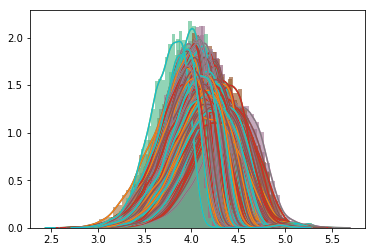

In [10]:
for layers in Layers:
    print(layers)
    
    # In case of early stopping there will be -1 on corresponding positions.
    # Errs has shape [Number_of_epochs_of_AL, 3*Number_of_repetitions]
    # Multiplier 3 because of 3 different losses: rmse, mae, maxae
    
    mcd_errs = np.zeros((num_of_iterations, 3 * repetitions)) - 1
    mcd_errs_train = np.zeros((num_of_iterations, 3 * repetitions)) - 1

    rnd_errs = np.zeros((num_of_iterations, 3 * repetitions)) - 1
    rnd_errs_train = np.zeros((num_of_iterations, 3 * repetitions)) - 1

    dmcd_errs = np.zeros((num_of_iterations, 3 * repetitions)) - 1
    dmcd_errs_train = np.zeros((num_of_iterations, 3 * repetitions)) - 1
    
    for j in range(repetitions):
        random_state = j * 10 + len(layers)
        random_states.append(random_state)
        X_train, y_train, X_test, y_test, X_pool, y_pool, X_val, y_val = generate_data(size, dimentionality, random_state)
        ndim = X_train.shape[1]
        points_to_sample = X_pool.shape[0] // (2 * num_of_iterations)
        print('How many points to sample: ', points_to_sample)
        
        path = './{}/{}/model_{}.ckpt'.format(folder, len(layers), len(layers))
        create_model(X_train, y_train, layers, path, lr_train, keeps_train, init_epochs_train, batch_size_train)


        
        print('random_sampling {}'.format(j))
        r = 0
        X_pool_rnd = X_pool.copy()
        y_pool_rnd = y_pool.copy()
        X_train_rnd = X_train.copy()  
        y_train_rnd = y_train.copy()
        sess, y, y_, x, l2_reg_, keep_probability_, saver, train_step, loss = model_loader(layers, path, lr_al)
        preds_train = sess.run(y, feed_dict= {x: X_train , keep_probability_: 1})
        preds_test = sess.run(y, feed_dict= {x: X_test , keep_probability_: 1})
        test_er =  get_errors(preds_test.squeeze(), y_test.squeeze())
        train_er = get_errors(preds_train.squeeze(), y_train.squeeze())
        print('Train errors: ', train_er)
        print('Test errors: ', test_er)
        min_error = test_er[0]
        min_error_rnd = min_error
        min_error_mcd = min_error
        min_error_dmcd = min_error
        for i in range(1, num_of_iterations + 1):
            if(i % 10 == 0):
                print(i)
            # random sampling
            if (r < tolerance):
                X_pool_rnd, y_pool_rnd, X_sample, y_sample = random_sampling(X_pool_rnd, y_pool_rnd, points_to_sample)
                X_train_rnd = np.concatenate((X_train_rnd, X_sample), axis=0)
                y_train_rnd = np.concatenate((y_train_rnd, y_sample), axis=0)
#                 path = './{}/{}/random_sampling/model_{}.ckpt'.format(folder, len(layers), i)
                test_er, tr_er = train_nn(X_train_rnd, y_train_rnd, sess, y, y_, 
                                          x, l2_reg_, keep_probability_, keeps, saver, train_step,
                                          loss, init_epochs, batch_size, X_test, y_test)
                rnd_errs[i - 1][3 * j] = test_er[0]
                rnd_errs[i - 1][3 * j + 1] = test_er[1]
                rnd_errs[i - 1][3 * j + 2] = test_er[2]
                rnd_errs_train[i - 1][3 * j] = tr_er[0]
                rnd_errs_train[i - 1][3 * j + 1] = tr_er[1]
                rnd_errs_train[i - 1][3 * j + 2] = tr_er[2]
                if (test_er[0] >= min_error_rnd):
                    r += 1
                else:
                    r = 0
                    min_error_rnd = test_er[0]
                print(tr_er)
                print(test_er)

        print('gmcdue_sampling {}'.format(j))
        g = 0
        X_pool_mcd = X_pool.copy()
        y_pool_mcd = y_pool.copy()
        X_train_mcd = X_train.copy()  
        y_train_mcd = y_train.copy()
        sess, y, y_, x, l2_reg_, keep_probability_, saver, train_step, loss = model_loader(layers, path, lr_al)
        for i in range(1, num_of_iterations + 1):
            if(i % 10 == 0):
                print(i)
            # MCDUE sampling
            if (g < tolerance): 
                X_pool_mcd, y_pool_mcd, X_sample, y_sample = GMCDUE_sampling(X_pool_mcd, y_pool_mcd, sess, y, x,
                                                                             keep_probability_, points_to_sample)
                X_train_mcd = np.concatenate((X_train_mcd, X_sample), axis=0)
                y_train_mcd = np.concatenate((y_train_mcd, y_sample), axis=0)
#                 path = './{}/{}/gmcdue_sampling/model_{}.ckpt'.format(folder, len(layers), i)
                test_er, tr_er = train_nn(X_train_mcd, y_train_mcd, sess, y, y_, x, l2_reg_, keep_probability_, 
                                          keeps, saver, train_step, loss, init_epochs, batch_size, X_test, y_test)
                mcd_errs[i - 1][3 * j] = test_er[0]
                mcd_errs[i - 1][3 * j + 1] = test_er[1]
                mcd_errs[i - 1][3 * j + 2] = test_er[2]
                mcd_errs_train[i - 1][3 * j] = tr_er[0]
                mcd_errs_train[i - 1][3 * j + 1] = tr_er[1]
                mcd_errs_train[i - 1][3 * j + 2] = tr_er[2]
                if (test_er[0] >= min_error_mcd):
                    g += 1
                else:
                    g = 0
                    min_error_mcd = test_er[0]
                print(tr_er)
                print(test_er)
            
            
        print('dmcdue_sampling {}'.format(j))
        d = 0
        X_pool_dmcd = X_pool.copy()
        y_pool_dmcd = y_pool.copy()
        X_train_dmcd = X_train.copy()  
        y_train_dmcd = y_train.copy()
        sess, y, y_, x, l2_reg_, keep_probability_, saver, train_step, loss = model_loader(layers, path, lr_al)
        for i in range(1, num_of_iterations + 1):
            if(i % 10 == 0):
                print(i)
            # Distribution based MCDUE sampling
            if (d < tolerance):
                X_pool_dmcd, y_pool_dmcd, X_sample, y_sample = DMCDUE_sampling(X_pool_dmcd, y_pool_dmcd, sess, y, x, 
                                                                               keep_probability_, points_to_sample)
                X_train_dmcd = np.concatenate((X_train_dmcd, X_sample), axis=0)
                y_train_dmcd = np.concatenate((y_train_dmcd, y_sample), axis=0)
#                 path = './{}/{}/dmcdue_sampling/model_{}.ckpt'.format(folder, len(layers), i)
                test_er, tr_er = train_nn(X_train_dmcd, y_train_dmcd, sess, y, y_, x, l2_reg_, keep_probability_,
                                          keeps,saver, train_step, loss, init_epochs, batch_size, X_test, y_test)

                dmcd_errs[i - 1][3 * j] = test_er[0]
                dmcd_errs[i - 1][3 * j + 1] = test_er[1]
                dmcd_errs[i - 1][3 * j + 2] = test_er[2]
                dmcd_errs_train[i - 1][3 * j] = tr_er[0]
                dmcd_errs_train[i - 1][3 * j + 1] = tr_er[1]
                dmcd_errs_train[i - 1][3 * j + 2] = tr_er[2]
                if (test_er[0] >= min_error_dmcd):
                    d += 1
                else:
                    d = 0
                    min_error_dmcd = test_er[0]
                print(tr_er)
                print(test_er)
        
        path = './{}/{}/random_sampling/'.format(folder, len(layers))
        if not os.path.exists(path):
            os.makedirs(path)
        path = './{}/{}/random_sampling/errors_test_{}.txt'.format(folder, len(layers), len(layers))
        np.savetxt(path, rnd_errs, fmt='%.5f' )
        path = './{}/{}/random_sampling/errors_train_{}.txt'.format(folder, len(layers), len(layers))
        np.savetxt(path, rnd_errs_train, fmt='%.5f' )

        path = './{}/{}/gmcdue_sampling/'.format(folder, len(layers))
        if not os.path.exists(path):
            os.makedirs(path)
        path = './{}/{}/gmcdue_sampling/errors_test_{}.txt'.format(folder, len(layers), len(layers))
        np.savetxt(path, mcd_errs, fmt='%.5f' )
        path = './{}/{}/gmcdue_sampling/errors_train_{}.txt'.format(folder, len(layers), len(layers))
        np.savetxt(path, mcd_errs_train, fmt='%.5f' )

        path = './{}/{}/dmcdue_sampling/'.format(folder, len(layers))
        if not os.path.exists(path):
            os.makedirs(path)
        path = './{}/{}/dmcdue_sampling/errors_test_{}.txt'.format(folder, len(layers), len(layers))
        np.savetxt(path, dmcd_errs, fmt='%.5f' )
        path = './{}/{}/dmcdue_sampling/errors_train_{}.txt'.format(folder, len(layers), len(layers))
        np.savetxt(path, dmcd_errs_train, fmt='%.5f' )

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [12]:
rmses_rnd = rnd_errs[:,2::3]
rmses_mcd = mcd_errs[:,2::3]
rmses_mcd2 = dmcd_errs[:,2::3]
rmses_rnd.shape

(20, 10)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


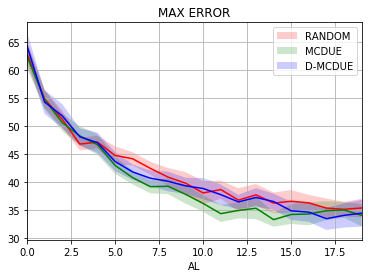

In [13]:
sns.tsplot(rmses_rnd.T, color='r')
sns.tsplot(rmses_mcd.T, color='g')
sns.tsplot(rmses_mcd2.T, color='b')
plt.title('MAX ERROR')
plt.xlabel('AL')
plt.grid()
plt.legend(['RANDOM','MCDUE','D-MCDUE'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


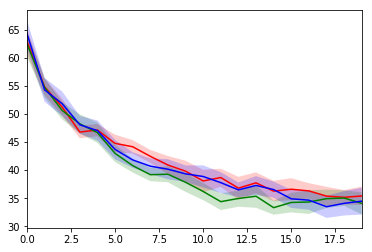

In [14]:
sns.tsplot(rmses_rnd.T, color='r')
sns.tsplot(rmses_mcd.T, color='g')
sns.tsplot(rmses_mcd2.T, color='b')

In [15]:
# Just to compare results of NNs with another strong model

from xgboost import XGBRegressor
reg = XGBRegressor(n_estimators=500)
reg.fit(X_train, y_train.squeeze())
print('XGBoost test lost: ', (np.mean((y_test.squeeze() - reg.predict(X_test))**2))**0.5)
print('XGBoost train lost: ', (np.mean((y_train.squeeze() - reg.predict(X_train))**2))**0.5)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBoost test lost:  14.699127558562218
XGBoost train lost:  9.19898559460003


In [1]:
import numpy as np

In [ ]:
np.re